In [15]:
# Section 1 - Imports
# -------------------

# imports
import datetime
import attotime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
from os.path import join
import copy

# DSO modules
from dsoclasses.doris.algorithms import beacon_nominal_frequency
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt, fsec2asec, to_attoseconds
from dsoclasses.orbits import sp3c, interpolator
from dsoclasses.geodesy import transformations
from dsoclasses.gnss import systems as gs
from dsoclasses.gnss import algorithms as alg
from dsoclasses.troposphere.vmf3 import SiteVmf3
from dsoclasses.sinex import sinex

In [16]:
# Section 2.1 – Define Files needed for analysis
# -----------------------------------------------
data_path = "/home/xanthos/Software/AcademicSoftware/data"
drinex = join(data_path, "ja3rx24001.001")
dpod = join(data_path, "dpod2020_041.snx")
dpod_freq_corr = join(data_path, "dpod2020_041_freq_corr.txt")
dsp3 = join(data_path, "ssaja320.b23359.e24003.DG_.sp3.001")
vmf3_data = join(data_path, "y2024.vmf3_d")

In [17]:
# Section 2.2 - Load Orbit Data + Initialize Interpolator
# -------------------------------------------------------
intrp = interpolator.Sp3Interpolator.from_sp3(dsp3, ['L'], interval_in_sec=310, min_data_pts=10, itype='Barycentric')
sat_id = list(intrp._interpolators.keys())[0]

In [18]:
# Section 2.3 - Intitialize DorisRinex and select a beacon (Dionysos/DIOB)
# ------------------------------------------------------------------------

rnx = DorisRinex(drinex)

site_name = 'DIOB'
result = sinex.extract_sinex_coordinates(dpod, [site_name], rnx.time_first_obs, True, dpod_freq_corr)
rsta = np.array([result[site_name]['X'], result[site_name]['Y'], result[site_name]['Z']])

# we are also going to need the geodetic coordinates of the site
lat, lon, hgt = transformations.car2ell(*rsta)

Slant total electron content (STEC) can be derived from carrier observations via:
$$
STEC = \frac{f_1^2 f_2^2}{40.3 (f_1^2 - f_2^2)} ((\lambda _1 \phi _1 - \lambda _2 \phi _2) - (\lambda _1 N _1 - \lambda _2 N _2))
$$

However, the derived data are affected by the jumps in carrier observations. Therefore, pass detection is performed to separate continuous arcs for the observed phase between a specific receiver and a DORIS beacon. This equation indicates that the obtained DORIS STEC is a **relative STEC**.

See:
Chen, J., Ren, X., Yang, P., Xu, G., Huang, L., Xiong, S., & Zhang, X. (2023). Global ionosphere modeling based on GNSS, satellite altimetry, radio occultation, and DORIS data considering ionospheric variation. Journal of Geophysical Research: Space Physics, 128, e2023JA031514. https://doi.org/10.1029/2023JA031514 

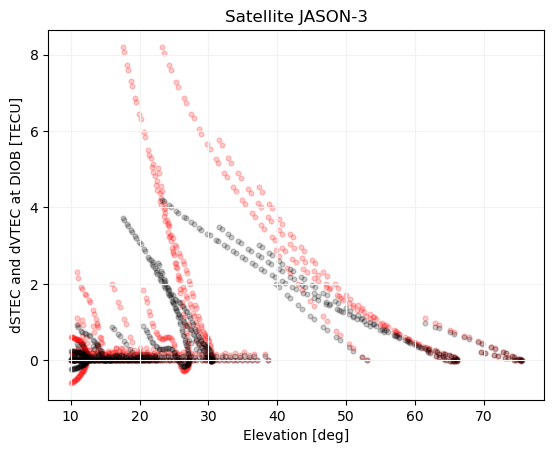

In [22]:
# nominal transmitting frequencies for selected beacon
# s1 -> 2GHz   channel
# u2 -> 400MHz channel
s1, u2 = beacon_nominal_frequency(rnx.kfactor(site_name))

C = 299792458e0 # speed of light in vacuum, [m/sec]
S = 40.3e16*((1.0/u2**2) - (1.0/s1**2))  # m/TECU (positive)
invS = 1.0/S


SAMPLE_GAP_MAX = 10.   # s, safer than 10s
ELEV_MIN = np.radians(10.)

def geometry_free_m(L1_cycles, L2_cycles):
    return (C/s1)*L1_cycles - (C/u2)*L2_cycles

def deltaD(u_hat): ## , dPCO_leo, dPCO_bcn):
    # if we don't have PCO vectors yet, return 0.0 temporarily
    dPCO_bcn = transformations.geodetic2lvlh(lat, lon) @ np.array([0e0, 0e0, 0.487])
    # dPCO_leo = np.array([0e0, 0e0, (0.555-0.9235)])
    dPCO_leo = np.array([0e0, 0e0, 0e0])
    return float(u_hat.dot(dPCO_leo - dPCO_bcn))

def is_slip(Lgf_prev, Lgf_curr, dt):
    # change in geometry-free phase too large for ionosphere in dt
    return abs(Lgf_curr - Lgf_prev) > 8e-1   # meters (tune: 0.5–2 m)

arcs = [] # list of arcs, each arc is list of per-epoch dicts
arc = []

prev_t = None
prev_Lgf = None

for block in rnx:
    for beacon, data in block:
        if beacon != rnx.name2id(site_name):
            continue

        t = block.t() + attotime.attotimedelta(nanoseconds=block.clock_offset()*1e9)
        satx, saty, satz, _ = intrp.sat_at(sat_id, t)
        rsat = np.array([satx, saty, satz])
        _, _, el = transformations.azele(rsat, rsta)
        if el < ELEV_MIN:
            continue

        Lgf = geometry_free_m(data['L1']['value'], data['L2']['value'])

        # LOS unit (beacon -> LEO)
        u = (rsat - rsta) / np.linalg.norm(rsat - rsta)
        # Dd = 0.0  # placeholder until PCO vectors are wired (see deltaD() above)
        Dd = deltaD(u)

        new_arc = False
        if prev_t is None:
            new_arc = True
        else:
            dt = (t - prev_t).total_seconds()
            if dt > SAMPLE_GAP_MAX or (prev_Lgf is not None and is_slip(prev_Lgf, Lgf, dt)):
                new_arc = True

        if new_arc:
            if arc:
                arcs.append(arc)
            arc = []

        arc.append({"t": t, "el": el, "Lgf": Lgf, "Dd": Dd, "rsat": rsat})
        prev_t = t
        prev_Lgf = Lgf

# push last arc
if arc:
    arcs.append(arc)

residuals = []; epochs = []; elevations = [];
# compute dSTEC per arc (all self-referenced to that arc's Emax)
all_dstec = []
for arc in arcs:
    # find epoch of max elevation inside this arc
    k = int(np.argmax([pt["el"] for pt in arc]))
    Lgf_ref = arc[k]["Lgf"]; 
    Dd_ref  = arc[k]["Dd"]

    for pt in arc:
        dL = (pt["Lgf"] - Lgf_ref) - (pt["Dd"] - Dd_ref)
        dstec = invS * dL   # TECU
        if abs(dstec) < 50.:
            all_dstec.append(dstec)
            epochs.append(pt["t"])
            elevations.append(pt["el"])

Re = 6371e3         # m
h_iono = 450e3      # m, choose to match your reference (e.g., GIM)

def mapping_factor(E):
    x = (Re*np.cos(E))/(Re + h_iono)
    return 1.0/np.sqrt(1.0 - x*x)

# dVTEC have dSTEC (relative):
dVTEC = [dstec_i / mapping_factor(el_i) for dstec_i, el_i in zip(all_dstec, elevations)]

plt.scatter([np.degrees(el) for el in elevations], all_dstec, alpha=0.2, s=12, c='red')
plt.scatter([np.degrees(el) for el in elevations], dVTEC, alpha=0.2, s=12, c='black')
plt.grid(color='0.95')
plt.ylabel(f"dSTEC and dVTEC at {site_name} [TECU]")
plt.title(f"Satellite {rnx.sat_name}")
plt.xlabel("Elevation [deg]")
plt.show()

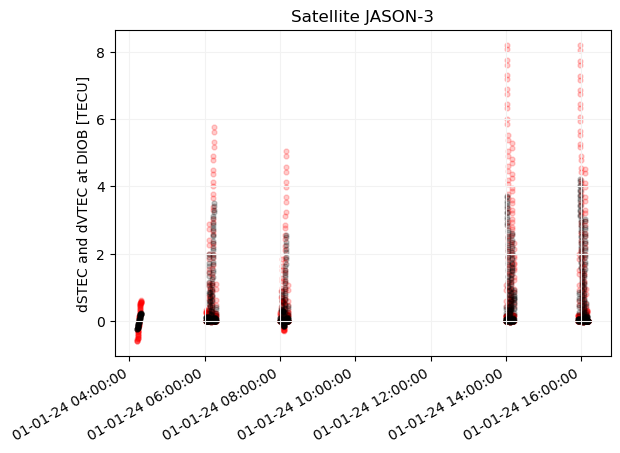

In [12]:
plt.scatter([at2pt(ti) for ti in epochs], all_dstec, alpha=0.2, s=12, c='red')
plt.scatter([at2pt(ti) for ti in epochs], dVTEC, alpha=0.2, s=12, c='black')
# plt.plot([at2pt(ti) for ti in epochs], all_dstec, c='red')

plt.grid(color='0.95')
plt.ylabel(f"dSTEC and dVTEC at {site_name} [TECU]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
plt.gcf().autofmt_xdate()
plt.show()